In [128]:
import numpy as np
import matplotlib.pyplot as plt


In this notebook we run the distributional DMD and the SKO algorithm on data coming from an SDE
$$ dX_t = a(X_t, t) dt + b(X_t, t) dW_t$$ 

If $b(x, t) = e^{-\frac{1}{2}V(x)}$, then the equation has a steady state solution of this SDE:
$$\rho \sim e^{-V(x)}$$
When implementing we will ignore the $t$ dependence in $a$ and $b$.

In [2]:
def euler_maruyama(x0, a, b, T, N):
    """
    implements the euler maruyama method with initial condition x0 and
    coefficients a and b, for time T. The interval [0, T] is partitioned
    in N steps
    """
    dt = T/N
    y = np.zeros(N + 1)
    y[0] = x0
    for i in range(N):
        y[i + 1] = y[i] + np.random.normal()* np.sqrt(dt)*b(y[i]) + a(y[i])* dt
    return y



### SKO on a long trajectory
We compute the $K_{SKO}$ matrix using a long trajectory, then we test its prediction for $\Delta t$ into the future. To test the prediction we generate K = 100 trajectories starting from $x = 0$ and compute the expectation of $h(X_t)$ along these trajectories. We then compare that to $K_{SKO} h(x)$ . Throughout we will use $\Delta t = 0.1$   
Select radial basis functions $$h_i = \phi_{c_i} = e^{-\epsilon (x - c)^2}$$
Here we select $c_i \in \{-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2\}$ and $\epsilon = 0.5$. 

Next we generate the data matrices $E_{ij} = h_i(x_j)$ and $D_{ij} = h_i(x_{j + 1})$
Finally, we compute the SKO Koopman matrix using the formula $K = DE^\dagger$. This is a summary of the function algorithm

### DKO on an ensemble of trajectories
First generate K = 1000 trajectories, each with initial condition sampled from $\mathcal{N}(0,\frac{1}{\sqrt{2}}) $
Next we generate data matrices E, D where now:
$$E_{ij} = h_i(\pi_j) = \frac{1}{K} \sum_{k = 1}^K \phi_{c_i} (data[k, j])$$ and 
$$D_{ij} = h_i(\pi_{j + 1}) = \frac{1}{K} \sum_{k = 1}^K \phi_{c_i} (data[k, j + 1])$$ 

In [150]:
def SKO(a, b, x0 = 0):
    r"""
        Implemetns the SKO algorithm, given a and  b 
        The number of steps in each simulation is N fixed, Dt is also fixed, the time for sko is T_KSO 
        The radial basis functions will be used throughout
    """
        # set hyperparameters
    T_SKO = 10
    N = 10000
 
    eps = 0.5
    # compute the trajectory for SKO
    Xt = euler_maruyama(x0, a, b, T_SKO, N)
    #plt.plot(np.linspace(0, T_SKO, N + 1), Xt)
    #plt.title("SKO trajectory")
    #plt.ylabel("Xt")
    #plt.xlabel("time")
    #plt.grid()
    
    # the SKO data will be the trajectory data with a step of Dt in between 
    current_step = T_SKO/N
    Xt = Xt[:: int(Dt/current_step)]
    #plt.plot(np.linspace(0, T, np.size(Xt)), Xt, label = "SKO data")
    #plt.legend()
    # plt.show()
    N_SKO = np.size(Xt)
    E_SKO = np.zeros((9, N_SKO -1))
    D_SKO = np.zeros((9, N_SKO -1))
    for i in range(9):
        c = -2 + i*0.5
        phi_c_Xt = np.exp(-eps* (Xt - c)**2)
        E_SKO[i, :] = phi_c_Xt[:-1]
        D_SKO[i, :] = phi_c_Xt[1:]
    K_SKO = D_SKO@np.linalg.pinv(E_SKO, rcond = 1e-5)
    return K_SKO
    
def DKO(a, b, distr = "trajectory", x0 = 0):
    r"""
        Implemetns the DKO algorithm, given a and  b 
        The number of steps in each simulation is N fixed, Dt is also fixed, the time for DKO is T_DKO
        K = number of samples in each measure
        The radial basis functions will be used throughout

        For the measures there are two options:
        - use trajectory i.e. we have a long \pi_t trajectory each consisting of K samples and we chose \mu_j = \pi_{j + 1}
        - use normal distributions centered at equidistant points between -2 and 2 with standard deviation 1
        - use dirac deltas at different locations as a starting point
        - assuming the data comes from one long mixing trajectory we construct measures to be conditional distributions
    """
    # set hyperparameters
    T_SKO = 10
    N = 10000
    eps = 0.5
    # compute the trajectory for SKO
    Xt = euler_maruyama(x0, a, b, T_SKO, N)

    # the SKO data will be the trajectory data with a step of Dt in between 
    current_step = T_SKO/N
    
    if distr == "trajectory":
        # number of samples 
        K = 100

        # number of measures = number of time steps on the trajectory since \mu_j = \pi_{j + 1}
        m = 100
        N_DKO = int(m*Dt/current_step)
        T_DKO = Dt*m
        data = np.zeros((K, N + 1))
        for j in range(K):
            # uncomment this if you want the initial distribution to be a delta at 0
            # x0 = 0

            # uncomment this if you want the initial distribution to be normal
            x0 = np.random.normal(loc = 0, scale = 1/np.sqrt(2))
            data[j, :] = euler_maruyama(x0, a, b, T_DKO, N_DKO)
        # DKO data is the trajectory data but with a step of Dt in between
        data = data[:, ::int(Dt/current_step)]

        # update the number of points in the data
        (_, N_DKO) = np.shape(data)

         # Compute the E and D matrices
        E_DKO = np.zeros((9, N_DKO - 1))
        D_DKO = np.zeros((9, N_DKO - 1))
        for i in range(9):
            c = -2 + i*0.5
            phi_c_data = np.zeros((N_DKO, ))
            for k in range(K):
                phi_c_data += 1/K*np.exp(-eps* (data[k, :] - c)**2)
            E_DKO[i, :] = phi_c_data[:-1]
            D_DKO[i, :] = phi_c_data[1:]

        #  uncomment to plot the ensemble of trajectories
        #for j in range(K):
        #    plt.plot(np.linspace(0, T_DKO, N_DKO), data[j, :])
        #plt.title("DKO data")
        #plt.grid()
        #plt.show()
    elif distr =="mixing_trajectory":
        # length of trajectory
        N = 10000

        # number of boxes
        m = 20
        
    else:
        # compute for one Dt time step the trajectory from different measures
        T_DKO = Dt
        N_DKO = int(N*T_DKO/T_SKO)
        # number of samples and number of different measures
        K = 1000
        m = 10
        E_DKO = np.zeros((9, m))
        D_DKO = np.zeros((9, m))
        data0 = np.zeros((m, K))
        data1 = np.zeros((m, K))
        for j in range(m):
            for k in range(K):
                # generate initial condition
                if distr == "normal":
                    x0 = np.random.normal()*0.4 - 2 + 0.4*j

                if distr == "uniform":
                    x0 = -2 + 4/m*j +  4 / m * np.random.uniform()
                data0[j, k] = x0
                trajx0 = euler_maruyama(x0, a, b, T_DKO, N_DKO)
                data1[j, k] = trajx0[-1]
  
        for i in range(9):
            c = -2 + i*0.5
            phi_c_data0 = np.zeros((m, ))
            phi_c_data1 = np.zeros((m, ))

            for k in range(K):
                phi_c_data0 += 1/K*np.exp(-eps* (data0[:, k] - c)**2)
                phi_c_data1 += 1/K*np.exp(-eps* (data1[:, k] - c)**2)
            E_DKO[i, :] = phi_c_data0
            D_DKO[i, :] = phi_c_data1
    K_DKO = D_DKO@np.linalg.pinv(E_DKO, rcond = 1e-5)
   
    return  K_DKO

def plot_eigens(K_SKO, K_DKO):
    # parameters
    eps= 0.5
     # Plot the eigenvalues and compare
    evals_SKO, evects_SKO = np.linalg.eig(K_SKO)
    plt.plot(np.real(evals_SKO), np.imag(evals_SKO), '.', label = 'SKO')
    plt.title("Eigenvalues")
    plt.grid()
    evals_DKO, evects_DKO = np.linalg.eig(K_DKO)
    plt.plot(np.real(evals_DKO), np.imag(evals_DKO), 'x', label = 'DKO')
    plt.legend()
    plt.show()

    # plot the dominant eigenfunctions and compare
    max_eval_SKO = np.argmax(evals_SKO)
    max_evect_SKO = evects_SKO[:, max_eval_SKO]
    max_eval_DKO = np.argmax(evals_DKO)
    max_evect_DKO = evects_DKO[:, max_eval_DKO]
    x = np.linspace(-2, 2, 100)
    eigf_SKO = np.zeros((100, ))
    eigf_DKO = np.zeros((100, ))
    for i in range(9):
        c = -2 + i*0.5
        eigf_SKO  = eigf_SKO + np.exp(-eps* (x - c)**2)*max_evect_SKO[i]
        eigf_DKO  = eigf_DKO + np.exp(-eps* (x - c)**2)*max_evect_DKO[i]

    plt.plot(x, np.real(eigf_SKO),'b',  label = "SKO")
    plt.plot(x, np.real(eigf_DKO), 'g', label = "DKO")
    plt.plot(x, np.imag(eigf_SKO), 'b')
    plt.plot(x, np.imag(eigf_DKO), 'g')
    plt.grid()
    plt.legend()
    plt.title("Dominant eigenfunction")
    plt.show()

# Predictions
 In order to find the expectation we generate 100 paths starting from $x_0$ and average them. We do this for $100$ different initial conditions between [-2, 2] and store each expectation in the rows of the matrix expectations. We compare this to the prediction of the SKO vs DKo algorithms given by $K_{N\Delta t} h_i(\delta_{x_j}) = \textbf{K}^N_{\Delta t} H$, where $H = h_i(\delta_{x_j})$

In [100]:
def prediction(K, a, b):
    """
        Given the formula for the SDE, and the matrix approximation K, it computes the predicted value of the radial basis functions 
        under the SDE for time T by repeatedly multiplying with K.
    """
    # hyperparameters: number of grid points for function evaluation
    N_x0 = 101
    x0 = np.linspace(-2, 2, N_x0)

    # number of dictionary functions
    n = 9

    # parameters of radial basis functions
    eps = 0.5
    
    # time duration and number of time steps
    T = 10
    N = int((T ) /(Dt))


    # compute the prediction for the expectation using the Koopman operator

    # array to hold the results dimension 3 represents the time of the prediction, dim 2 is the evaluation point $\delta_x_j$ and 
    # dim 1 is the observable
    
    predictions = np.zeros((n, N_x0, N + 1))

    # matrix H_ij = h_i(\delta_x_j)         
    H = np.zeros((n, N_x0))
    for i in range(n):
        c = -2 + i*0.5
        for xx in range(N_x0):
            H[i, xx] = np.exp(-eps* ( x0[xx]- c)**2)

    predictions[:, :, 0] = H
    for j in range(1, N + 1):
        predictions[:, :, j] = K @ predictions[:, :, j -1] 
    return  predictions

def expectations(a, b):
    """
        Given the formula for the SDE, it computes the expected value of the radial basis functions 
        under the SDE for time T = 10
    """

    # parameters

    # time duration 
    T = 10

    # distance between two consecutive time steps
    #Dt = 1

    # how many grid points we approximate the function on
    N_x0 = 101

    # number of observables
    n = 9
    # parameters of radial basis functions
    eps = 0.5

    # number of trajectories to compute expectation over
    N_sample = 100

    # compute the expectation for N time steps
    N = int((T) /(Dt))

    x0 = np.linspace(-2, 2, N_x0)

    # array to hold for each observable, and each grid point, for each time, the position of each trajectory
    data_predictions = np.zeros((n, N_x0, N + 1, N_sample))
    for i in range(n):
        c = -2 + i*0.5
        for xx in range(N_x0):
            for repeat in range( N_sample):
                    data_predictions[i, xx, :, repeat] = np.exp(-eps* ( euler_maruyama(x0[xx], a, b, T + Dt, N)- c)**2)
    expectations = 1/N_sample * np.sum(data_predictions, axis = 3)
    return expectations

Using the same algorithm we compute the DKO and SKO matrix approximations for the below cases, and plot as before the eigenvalues, and dominant  eigenfunction
# I. State independent noise, ergodic trajectory
$$dX_t = - \sin{x} dt + dB_t$$

SKO and DKO need to see the same time intervals. 

In [158]:
def a(x):
    return -np.sin(x)
def b(x):
    return 1 #0.2*np.exp(-0.5*(x-1)**2)
    
Dt = 0.1
K_SKO = SKO(a, b)
#K_DKO = DKO(a, b, distr = "normal")

In [146]:
truth = expectations(a, b)

for plotting purposes look at the prediction of g = 1/n h_n and in order to compute the accuracy we find the mean square error across
the domain

In [159]:
pred_SKO = prediction(K_SKO, a, b)
pred_DKO = prediction(K_DKO, a, b)

9 101 101
(101, 101)
101
(101,)


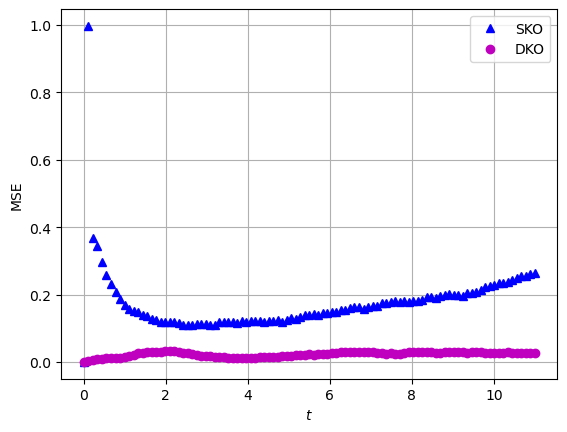

In [160]:
n, N_x0, N = np.shape(truth)
print(n, N, N_x0)
g_pred_SKO = 1/n* np.sum(pred_SKO, axis = 0)
g_pred_DKO = 1/n* np.sum(pred_DKO, axis = 0)

g_true = 1/n*np.sum(truth, axis = 0)
#g_pred_SKO = pred_SKO[3, :, :]
#g_pred_DKO = pred_DKO[3, :, :]
#g_true = truth[3, :, :]
#mean_square_error_SKO = np.sum((g_true - g_pred_SKO)**2, axis = 0)/N_x0
#mean_square_error_DKO = np.sum((g_true - g_pred_DKO)**2, axis = 0)/N_x0

mean_square_error_SKO = np.trapezoid((g_true - g_pred_SKO)**2, axis = 0)
mean_square_error_DKO = np.trapezoid((g_true - g_pred_DKO)**2, axis = 0)
print(np.shape(g_true))
print(N)
print(np.shape(mean_square_error_DKO))
# try trapezoidal rule instead
plt.plot(np.linspace(0, 11, N ), mean_square_error_SKO, 'b^',label = "SKO")
plt.plot(np.linspace(0, 11, N ), mean_square_error_DKO, 'mo', label = "DKO")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("MSE")
plt.grid()
#plt.ylim(0,1)
#plt.xlim(0, 2)
plt.show()
#plot_eigens(K_SKO, K_DKO)

In [135]:
# save the data that produced plots 
K_DKO_traj = K_DKO
K_SKO_traj = K_SKO

In [161]:
K_DKO_normal = K_DKO
K_SKO_normal = K_SKO

(101, 101)
101
(101,)


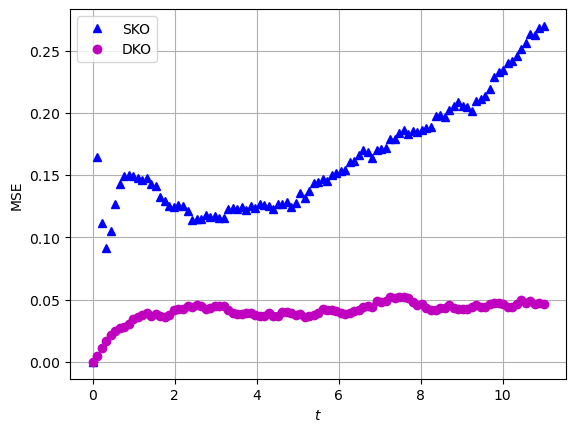

In [157]:
pred_SKO = prediction(K_SKO_traj, a, b)
pred_DKO = prediction(K_DKO_traj, a, b)

g_pred_SKO = 1/n* np.sum(pred_SKO, axis = 0)
g_pred_DKO = 1/n* np.sum(pred_DKO, axis = 0)

g_true = 1/n*np.sum(truth, axis = 0)
#g_pred_SKO = pred_SKO[3, :, :]
#g_pred_DKO = pred_DKO[3, :, :]
#g_true = truth[3, :, :]
#mean_square_error_SKO = np.sum((g_true - g_pred_SKO)**2, axis = 0)/N_x0
#mean_square_error_DKO = np.sum((g_true - g_pred_DKO)**2, axis = 0)/N_x0

mean_square_error_SKO = np.trapezoid((g_true - g_pred_SKO)**2, axis = 0)
mean_square_error_DKO = np.trapezoid((g_true - g_pred_DKO)**2, axis = 0)
print(np.shape(g_true))
print(N)
print(np.shape(mean_square_error_DKO))
# try trapezoidal rule instead
plt.plot(np.linspace(0, 11, N ), mean_square_error_SKO, 'b^',label = "SKO")
plt.plot(np.linspace(0, 11, N ), mean_square_error_DKO, 'mo', label = "DKO")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("MSE")
plt.grid()
#plt.ylim(0,1)
#plt.xlim(0, 2)
plt.show()
#plot_eigens(K_SKO, K_DKO)

# II. State dependent noise, ergodic trajectory

The equations of motion are 
$$ dX_t = -sin(X_t) + 0.2e^{-0.5 (x - 1)^2}dB_t$$

In [162]:
def a(x):
    return -np.sin(x)
def b(x):
    return  0.2*np.exp(-0.5*(x-1)**2)
K_SKO = SKO(a, b)
K_DKO = DKO(a, b)


In [163]:
truth_dependent = expectations(a, b)

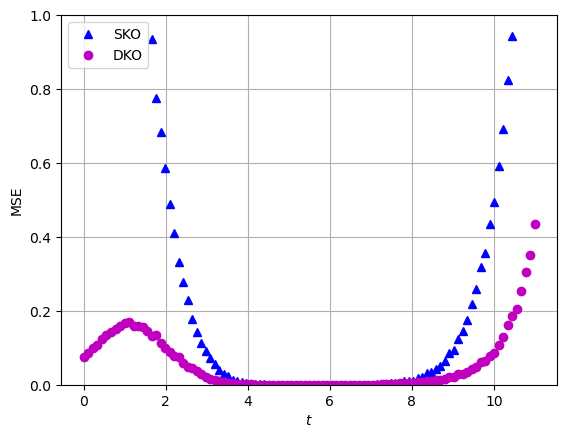

In [166]:
pred_SKO = prediction(K_SKO, a, b)
pred_DKO = prediction(K_DKO, a, b)
g_pred_SKO = 1/n* np.sum(pred_SKO, axis = 0)
g_pred_DKO = 1/n* np.sum(pred_DKO, axis = 0)

g_true = 1/n*np.sum(truth_dependent, axis = 0)

mean_square_error_SKO = np.trapezoid((g_true - g_pred_SKO)**2)
mean_square_error_DKO = np.trapezoid((g_true - g_pred_DKO)**2)
# try trapezoidal rule instead
plt.plot(np.linspace(0, 11, N ), mean_square_error_SKO, 'b^',label = "SKO")
plt.plot(np.linspace(0, 11, N ), mean_square_error_DKO, 'mo', label = "DKO")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("MSE")
plt.grid()
plt.ylim(0,1)
#plt.xlim(0, 2)
plt.show()


# III. State dependent noise, trajectory not ergodic

In [84]:
K_SKO, K_DKO = algorithm(a, b, distr  = "delta")


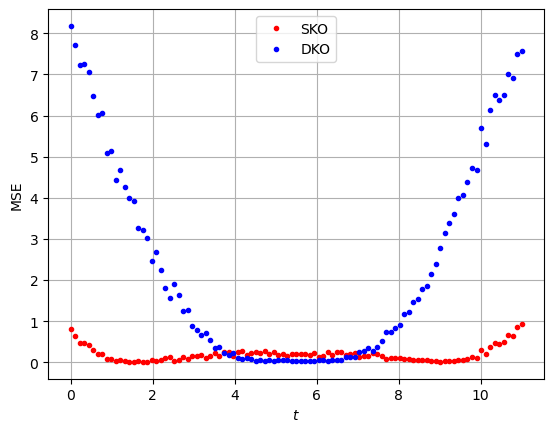

In [85]:
pred_SKO = prediction(K_SKO, a, b)
pred_DKO = prediction(K_DKO, a, b)
g_pred_SKO = 1/n* np.sum(pred_SKO, axis = 0)
g_pred_DKO = 1/n* np.sum(pred_DKO, axis = 0)

g_true = 1/n*np.sum(truth, axis = 0)
#g_pred_SKO = pred_SKO[3, :, :]
#g_pred_DKO = pred_DKO[3, :, :]
#g_true = truth[3, :, :]
#mean_square_error_SKO = np.sum((g_true - g_pred_SKO)**2, axis = 0)/N_x0
#mean_square_error_DKO = np.sum((g_true - g_pred_DKO)**2, axis = 0)/N_x0

mean_square_error_SKO = np.trapezoid((g_true - g_pred_SKO)**2)
mean_square_error_DKO = np.trapezoid((g_true - g_pred_DKO)**2)
# try trapezoidal rule instead
plt.plot(np.linspace(0, 11, N ), mean_square_error_SKO, 'r.',label = "SKO")
plt.plot(np.linspace(0, 11, N ), mean_square_error_DKO, 'b.', label = "DKO")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("MSE")
plt.grid()
#plt.ylim(0,1)
#plt.xlim(0, 2)
plt.show()

# IV. Variance